<a href="https://colab.research.google.com/github/LudovicaCi/CIDL_Project/blob/main/CNN_training_balanced_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Balancing the Dataset


In [ ]:
import os
import random
from tqdm import tqdm
import cv2
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# setup directory for training and test dataset
train_path = '/content/drive/Shareddrives/Cocchella_Cantini/Dataset/train'

In [ ]:
# Create a dictionary to map class indices to class names
classes = {
    0: 'angry',
    1: 'disgusted',
    2: 'fearful',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprised'
}

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Upload immages
image_data_by_class = {class_index: [] for class_index in classes.keys()}

for class_index in classes.keys():
    path = train_path + '/' + str(class_index)
    images = os.listdir(path)

    for img in tqdm(images, desc=f"Class {class_index}"):
        try:
            image_path = path + '/' + img
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image_data_by_class[class_index].append(np.array(image))
        except:
            print("Error in " + img)

# convert from list to numpy arrays
for class_index in classes.keys():
    image_data_by_class[class_index] = np.array(image_data_by_class[class_index])

# Print size
for class_index, images in image_data_by_class.items():
    print(f"Class {class_index}: {images.shape}")


Class 6: 100%|██████████| 3171/3171 [00:07<00:00, 412.03it/s]

Class 0: (3995, 48, 48)
Class 1: (436, 48, 48)
Class 2: (4097, 48, 48)
Class 3: (7215, 48, 48)
Class 4: (4965, 48, 48)
Class 5: (4830, 48, 48)
Class 6: (3171, 48, 48)


In [ ]:
# Save arrays into .npy files
save_dir = '/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np'
os.makedirs(save_dir, exist_ok=True)

for class_index, images in image_data_by_class.items():
    file_path = os.path.join(save_dir, f'class_{class_index}.npy')
    np.save(file_path, images)

print("Arrays salvati con successo!")

Arrays salvati con successo!


In [ ]:
from sklearn.model_selection import train_test_split

train_data_by_class = {}
valid_data_by_class = {}

for class_index, images in image_data_by_class.items():
    # Split dataset into train e validation sets
    X_train, X_valid = train_test_split(images, test_size=0.2, random_state=42)

    # Save sets into dictionaries
    train_data_by_class[class_index] = X_train
    valid_data_by_class[class_index] = X_valid


In [ ]:
# Print size for each class
for class_index in classes.keys():
    print(f"Class {class_index}:")
    print(f"Training set size: {train_data_by_class[class_index].shape}")
    print(f"Validation set size: {valid_data_by_class[class_index].shape}")

Class 0:
Training set size: (3196, 48, 48)
Validation set size: (799, 48, 48)
Class 1:
Training set size: (348, 48, 48)
Validation set size: (88, 48, 48)
Class 2:
Training set size: (3277, 48, 48)
Validation set size: (820, 48, 48)
Class 3:
Training set size: (5772, 48, 48)
Validation set size: (1443, 48, 48)
Class 4:
Training set size: (3972, 48, 48)
Validation set size: (993, 48, 48)
Class 5:
Training set size: (3864, 48, 48)
Validation set size: (966, 48, 48)
Class 6:
Training set size: (2536, 48, 48)
Validation set size: (635, 48, 48)


In [ ]:
# Save validation set into .npy files
save_dir = '/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/Balanced_Dataset/Validation'

for class_index, images in  valid_data_by_class.items():
    file_path = os.path.join(save_dir, f'class_{class_index}.npy')
    np.save(file_path, images)

print("Arrays salvati con successo!")

Arrays salvati con successo!


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_train_data_by_class = {}
images_to_add = 5772  #Number images for each class

for class_index, images in train_data_by_class.items():
    num_images = len(images)
    if num_images < images_to_add:
        # COmpute how many batch you need to reach images_to_add
        batches_needed = (images_to_add - num_images) // 32 + 1  # Batch size 32

        # Add a color channel to gray scale images
        images_with_channel = np.expand_dims(images, axis=-1)

        # generate images with data augmentation
        augmented_images = []
        for _ in range(batches_needed):
            batch = next(datagen.flow(images_with_channel, batch_size=32, shuffle=False))
            augmented_images.extend(batch)

        # Add images to existing arrays
        augmented_images = np.array(augmented_images)
        augmented_images = np.squeeze(augmented_images, axis=-1)  # Rimuovi il canale di colore aggiunto
        augmented_train_data_by_class[class_index] = np.concatenate((images, augmented_images), axis=0)
    else:
        augmented_train_data_by_class[class_index] = images


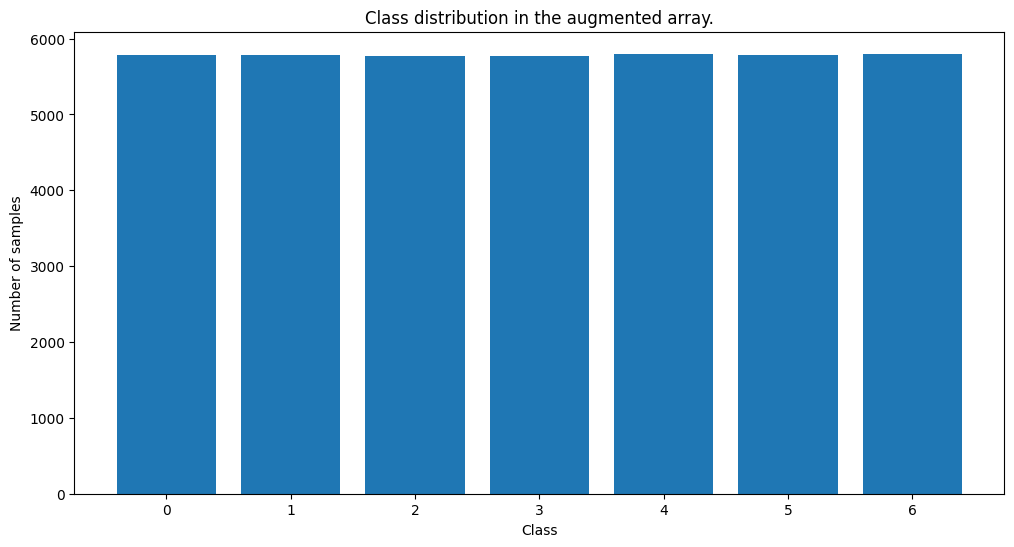

In [ ]:
import matplotlib.pyplot as plt

# Compute the number of sample for each class after data augmentation
class_counts_augmented = {class_index: len(images) for class_index, images in augmented_train_data_by_class.items()}

# Plot graph
plt.figure(figsize=(12, 6))
plt.bar(class_counts_augmented.keys(), class_counts_augmented.values())
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution in the augmented array.')
plt.show()

In [ ]:
# Save array into .npy files
save_dir = '/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/Balanced_Dataset/Train'

for class_index, images in  augmented_train_data_by_class.items():
    file_path = os.path.join(save_dir, f'class_{class_index}.npy')
    np.save(file_path, images)

print("Arrays salvati con successo!")

Arrays salvati con successo!


# Import

In [ ]:
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.layers import BatchNormalization
from keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras.metrics import Metric
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import resample

# Upload the dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

img_train = []
label_train = []
img_val = []
label_val = []

# Upload array for each class
num_classes = 7
for classe in range(num_classes):
    augmented_file = f'/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/Balanced_Dataset/Train/class_{classe}.npy'
    valid_file = f'/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/Balanced_Dataset/Validation/class_{classe}.npy'

    data_augmented = np.load(augmented_file)
    img_train.append(data_augmented)
    label_train.append(np.full(data_augmented.shape[0], classe))

    data_valid = np.load(valid_file)
    img_val.append(data_valid)
    label_val.append(np.full(data_valid.shape[0], classe))

# Convert from list to array
img_train = np.concatenate(img_train)
label_train = np.concatenate(label_train)
img_val = np.concatenate(img_val)
label_val = np.concatenate(label_val)

In [ ]:
#we mix the train array
shuffle_indexes = np.arange(img_train.shape[0])
np.random.shuffle(shuffle_indexes)
img_train = img_train[shuffle_indexes]
label_train = label_train[shuffle_indexes]

In [ ]:
#we mix the val array
shuffle_indexes = np.arange(img_val.shape[0])
np.random.shuffle(shuffle_indexes)
img_val = img_val[shuffle_indexes]
label_val = label_val[shuffle_indexes]

In [ ]:
final_img_train_np = img_train
final_img_valid_np = img_val
final_label_train_np = label_train
final_label_valid_np = label_val

In [ ]:
img_train_norm = final_img_train_np.astype('float32') / 255
img_val_norm = final_img_valid_np.astype('float32') / 255

In [ ]:
img_train_norm = img_train_norm.reshape(img_train_norm.shape[0], img_train_norm.shape[1], img_train_norm.shape[2], 1)
img_val_norm = img_val_norm.reshape(img_val_norm.shape[0], img_val_norm.shape[1], img_val_norm.shape[2], 1)

In [ ]:
# Convert labels to categorical format
categorical_label_train = to_categorical(final_label_train_np)
categorical_label_val = to_categorical(final_label_valid_np)

In [ ]:
print(categorical_label_train[0])
print(categorical_label_val[0])

[1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]


# CNN from scratch on balanced dataset


## Model


In [ ]:
# Define the CNN model

model = models.Sequential()

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(48, 48, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# Third convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# fifth convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# seventh convolutional layer
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# Flattening Layer
model.add(layers.Flatten())

# first dense layer
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# third dense layer (output)
model.add(layers.Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_21 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_22 (Ba  (None, 24, 24, 32)        128       
 tchNormalization)                                               
                                                      

In [ ]:
# Create an instance of EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=10,             # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore the model with the best weights
)

# Create ImageDataGenerator object with data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/Shareddrives/Cocchella_Cantini/models/BalancedCnnModelFromScratch.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True)

# Train the model with data augmentation and class weights
history = model.fit(
    datagen.flow(img_train_norm, categorical_label_train, batch_size=64),
    epochs=200,
    callbacks=[early_stopping, checkpoint],
    validation_data=(img_val_norm, categorical_label_val),
    shuffle=True)

Epoch 1/200
632/633 [============================>.] - ETA: 0s - loss: 1.8071 - accuracy: 0.3850

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


633/633 [==============================] - 33s 42ms/step - loss: 1.8064 - accuracy: 0.3852 - val_loss: 1.6293 - val_accuracy: 0.4016
Epoch 2/200
633/633 [==============================] - 26s 41ms/step - loss: 1.1892 - accuracy: 0.5762 - val_loss: 1.5446 - val_accuracy: 0.4022
Epoch 3/200
633/633 [==============================] - 27s 42ms/step - loss: 1.0113 - accuracy: 0.6413 - val_loss: 1.3783 - val_accuracy: 0.4885
Epoch 4/200
633/633 [==============================] - 27s 42ms/step - loss: 0.9127 - accuracy: 0.6749 - val_loss: 1.2830 - val_accuracy: 0.5211
Epoch 5/200
633/633 [==============================] - 27s 42ms/step - loss: 0.8489 - accuracy: 0.6949 - val_loss: 1.2151 - val_accuracy: 0.5331
Epoch 6/200
633/633 [==============================] - 27s 42ms/step - loss: 0.8097 - accuracy: 0.7083 - val_loss: 1.2753 - val_accuracy: 0.5205
Epoch 7/200
633/633 [==============================] - 28s 44ms/step - loss: 0.7723 - accuracy: 0.7190 - val_loss: 1.2410 - val_accuracy: 0.52

## Evaluation and Test

In [ ]:
from sklearn import metrics
import seaborn as sn

def evaluateClassifier(model, testset, actual):
  font = {'size'   : 16}
  plt.rc('font', **font)
  pred = model.predict(testset)

  y_classes = pred.argmax(axis=-1)
  y_classes = to_categorical(y_classes)

  y_test_non_category = [ np.argmax(t) for t in actual ]
  y_predict_non_category = [ np.argmax(t) for t in y_classes ]
  conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
  print(metrics.classification_report(y_test_non_category, y_predict_non_category))

  # plot confusion matrix
  group_counts = ['{:.0f}'.format(value) for value in conf_mat.flatten()]
  group_percentages = [('{:.2f}'.format(value))[1:] for value in (conf_mat / np.sum(conf_mat, axis=1)).flatten()]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(7,7) # 7 is the number of classes
  fig, ax = plt.subplots(figsize=(11,10))
  plt.title('Confusion matrix')
  sn.heatmap(conf_mat, annot=labels, fmt='', cmap="OrRd", ax=ax)
  font = {'size'   : 20}
  plt.rc('font', **font)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()



def plot_accurancy_loss(hist):
  """ utility function to plot training and validation curves"""

  plt.rcParams["figure.figsize"] = (7,5)
  font = {'size'   : 24}
  plt.rc('font', **font)

  acc_1 = hist.history['accuracy']
  val_acc_1 = hist.history['val_accuracy']
  loss_1 = hist.history['loss']
  val_loss_1 = hist.history['val_loss']
  epochs = range(len(acc_1))

  plt.figure()
  plt.plot(epochs, loss_1, 'C1', alpha=0.6, label='Training loss', linewidth=3.5)
  plt.plot(epochs, val_loss_1, 'C2', alpha=0.6, label='Validation loss', linewidth=3.5)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(prop={'size': 24}, loc="upper right")
  plt.show()

  plt.ylim(0,1)
  plt.plot(epochs, acc_1, 'C1', alpha=0.6, linewidth=3.5, label='Training acc')
  plt.plot(epochs, val_acc_1, 'C2', alpha=0.6, linewidth=3.5, label='Validation acc')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(prop={'size': 24}, loc="lower right")

  plt.show()

In [ ]:
test_path = '/content/drive/Shareddrives/CIDL/Dataset/Test/test_1'

#we put all test image with classes in np array
image_test_np = []
label_test_np = []

for class_index in classes.keys():
  path = test_path + '/' + str(class_index)
  images = os.listdir(path)

  for img in tqdm(images, desc=f"Class {class_index}"):
        try:
            image_path = path + '/' + img
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image_test_np.append(np.array(image))
            label_test_np.append(class_index)
        except:
            print("Error in " + img)

# Convert the list into a numpy array
image_test_np = np.array(image_test_np)
label_test_np = np.array(label_test_np)


print(image_test_np.shape, label_test_np.shape)

Class 6: 100%|██████████| 831/831 [00:09<00:00, 83.60it/s] 

(7178, 48, 48) (7178,)


In [ ]:
np.save('/content/drive/MyDrive/numpy_arrays_test/image_test_grey_np.npy', image_test_np)
np.save('/content/drive/MyDrive/numpy_arrays_test/label_test_grey_np.npy', label_test_np)

In [ ]:
image_test_np = np.load('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/image_test_gray_np.npy')
label_test_np = np.load('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/label_test_gray_np.npy')

In [ ]:
image_test_norm = image_test_np.astype('float32') / 255

(7178, 48, 48, 1)


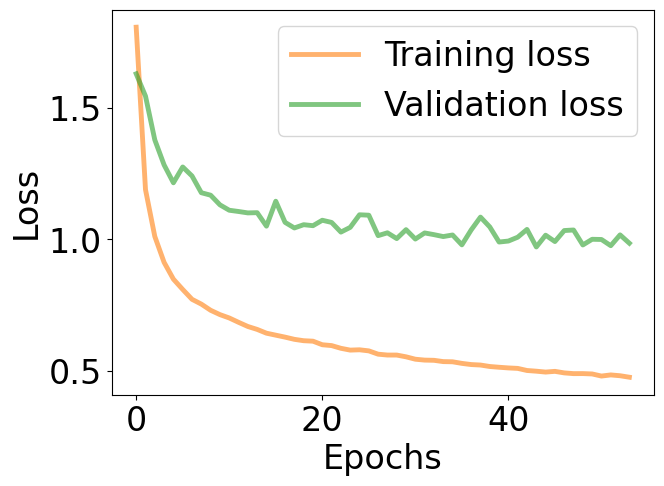

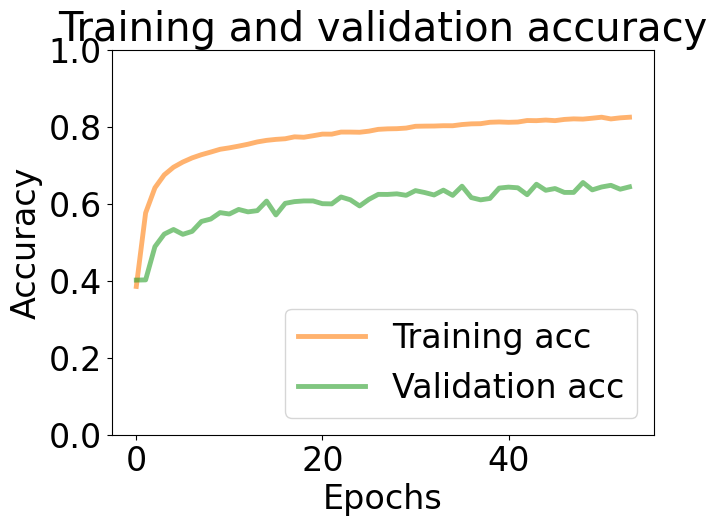

225/225 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.52      0.60      0.56       958
           1       0.88      0.41      0.56       111
           2       0.55      0.40      0.46      1024
           3       0.88      0.83      0.86      1774
           4       0.52      0.78      0.62      1233
           5       0.57      0.43      0.49      1247
           6       0.77      0.79      0.78       831

    accuracy                           0.65      7178
   macro avg       0.67      0.60      0.62      7178
weighted avg       0.66      0.65      0.64      7178



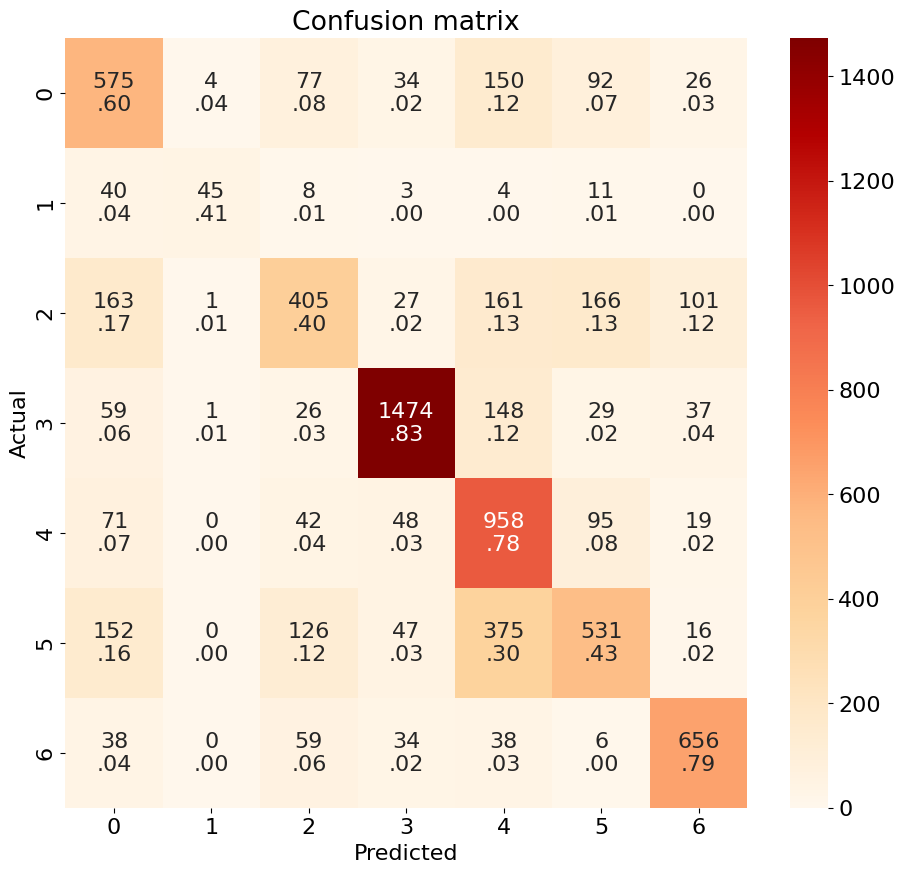

In [ ]:
import matplotlib.pyplot as plt

# Convert labels to categorical format
categorical_label_test = to_categorical(label_test_np)

print(image_test_norm.shape)

# reshape test set
image_test_norm = image_test_norm.reshape(image_test_norm.shape[0], image_test_norm.shape[1], image_test_norm.shape[2], 1)

plot_accurancy_loss(history)
evaluateClassifier(model, image_test_norm, categorical_label_test)

# Pretrained network

In [ ]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

In [ ]:
from tensorflow.keras.applications import VGG16

model = keras.Sequential()

pretrained_model = keras.applications.vgg16.VGG16(include_top=False,
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),classes=7,
                                        weights='imagenet')

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
import numpy as np

print('This is the number of trainable weights '
      'before freezing the conv base:', sum(np.prod(x.shape) for x in pretrained_model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 14714688


In [ ]:
pretrained_model.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', sum(np.prod(x.shape) for x in pretrained_model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
model.add(pretrained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))
# Output layer
model.add(layers.Dense(7, activation='softmax'))
# Compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 14847815 (56.64 MB)
Trainable params: 133127 (520.03 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Reshape of the input into 3 channel
img_train_rgb = np.repeat(img_train_norm, 3, axis=-1)
img_val_rgb = np.repeat(img_val_norm, 3, axis=-1)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create an instance of EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=10,             # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore the model with the best weights
)

# Create ImageDataGenerator object with data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/Shareddrives/Cocchella_Cantini/models/BalancedFeatureExtractionVGG16.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [ ]:
# Train the model with data augmentation and class weights
history = model.fit(
    datagen.flow(img_train_rgb, categorical_label_train, batch_size=64),
    epochs=200,
    callbacks=[early_stopping, checkpoint],
    validation_data=(img_val_rgb, categorical_label_val),
    shuffle=True)

Epoch 1/200
633/633 [==============================] - ETA: 0s - loss: 1.6675 - accuracy: 0.3575

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


633/633 [==============================] - 71s 90ms/step - loss: 1.6675 - accuracy: 0.3575 - val_loss: 1.6729 - val_accuracy: 0.3449
Epoch 2/200
633/633 [==============================] - 49s 77ms/step - loss: 1.4721 - accuracy: 0.4497 - val_loss: 1.6495 - val_accuracy: 0.3574
Epoch 3/200
633/633 [==============================] - 49s 78ms/step - loss: 1.3873 - accuracy: 0.4877 - val_loss: 1.6304 - val_accuracy: 0.3604
Epoch 4/200
633/633 [==============================] - 49s 78ms/step - loss: 1.3339 - accuracy: 0.5137 - val_loss: 1.6171 - val_accuracy: 0.3734
Epoch 5/200
633/633 [==============================] - 48s 76ms/step - loss: 1.3038 - accuracy: 0.5272 - val_loss: 1.6152 - val_accuracy: 0.3712
Epoch 6/200
633/633 [==============================] - 49s 78ms/step - loss: 1.2721 - accuracy: 0.5384 - val_loss: 1.6023 - val_accuracy: 0.3794
Epoch 7/200
633/633 [==============================] - 49s 77ms/step - loss: 1.2451 - accuracy: 0.5505 - val_loss: 1.5957 - val_accuracy: 0.38

## Fine tuning

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
pretrained_model = keras.applications.vgg16.VGG16(include_top=False,
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),classes=7,
                                        weights='imagenet')


pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
pretrained_model.trainable = True

set_trainable = False
for layer in pretrained_model.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model = keras.Sequential()

model.add(pretrained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
# Output layer
model.add(layers.Dense(7, activation='softmax'))
# Compile the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 14847815 (56.64 MB)
Trainable params: 13112327 (50.02 MB)
Non-trainable params: 1735488 (6.62 MB)
_________________________________________________________________


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create ImageDataGenerator object with data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

#earlystopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 5,
    restore_best_weights = True,
    verbose = 1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/Shareddrives/Cocchella_Cantini/models/BalancedFineTuningVGG16.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [ ]:
# reshape train set
img_train_norm = img_train_norm.reshape(img_train_norm.shape[0], img_train_norm.shape[1], img_train_norm.shape[2], 1)
# Reshape of the input into 3 channel
image_train_rgb = np.repeat(img_train_norm, 3, axis=-1)

print(image_train_rgb.shape)

(40501, 48, 48, 3)


In [ ]:
# reshape val set
img_val_norm = img_val_norm.reshape(img_val_norm.shape[0], img_val_norm.shape[1], img_val_norm.shape[2], 1)
# Reshape of the input into 3 channel
image_val_rgb = np.repeat(img_val_norm, 3, axis=-1)

print(image_val_rgb.shape)

(5744, 48, 48, 3)


In [ ]:
# Train the model with data augmentation and class weights
history = model.fit(
    datagen.flow(image_train_rgb, categorical_label_train, batch_size=64),
    epochs=200,
    callbacks=[early_stopping, checkpoint],
    validation_data=(image_val_rgb, categorical_label_val),
    shuffle=True)

Epoch 1/200
633/633 [==============================] - 60s 87ms/step - loss: 1.5971 - accuracy: 0.3867 - val_loss: 1.5031 - val_accuracy: 0.4340
Epoch 2/200
633/633 [==============================] - 59s 92ms/step - loss: 1.1232 - accuracy: 0.6034 - val_loss: 1.4023 - val_accuracy: 0.4671
Epoch 3/200
633/633 [==============================] - 58s 91ms/step - loss: 0.9435 - accuracy: 0.6725 - val_loss: 1.3531 - val_accuracy: 0.4977
Epoch 4/200
633/633 [==============================] - 59s 93ms/step - loss: 0.8551 - accuracy: 0.7013 - val_loss: 1.2766 - val_accuracy: 0.5207
Epoch 5/200
633/633 [==============================] - 55s 87ms/step - loss: 0.8008 - accuracy: 0.7187 - val_loss: 1.2338 - val_accuracy: 0.5322
Epoch 6/200
633/633 [==============================] - 58s 92ms/step - loss: 0.7556 - accuracy: 0.7328 - val_loss: 1.2053 - val_accuracy: 0.5465
Epoch 7/200
633/633 [==============================] - 55s 87ms/step - loss: 0.7235 - accuracy: 0.7427 - val_loss: 1.2018 - val_ac

# test pretrained model

In [ ]:
from sklearn import metrics
import seaborn as sn

def evaluateClassifier(model, testset, actual):
  font = {'size'   : 16}
  plt.rc('font', **font)
  pred = model.predict(testset)

  y_classes = pred.argmax(axis=-1)
  y_classes = to_categorical(y_classes)

  y_test_non_category = [ np.argmax(t) for t in actual ]
  y_predict_non_category = [ np.argmax(t) for t in y_classes ]
  conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
  print(metrics.classification_report(y_test_non_category, y_predict_non_category))

  # plot confusion matrix
  group_counts = ['{:.0f}'.format(value) for value in conf_mat.flatten()]
  group_percentages = [('{:.2f}'.format(value))[1:] for value in (conf_mat / np.sum(conf_mat, axis=1)).flatten()]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(7,7) # 7 is the number of classes
  fig, ax = plt.subplots(figsize=(11,10))
  plt.title('Confusion matrix')
  sn.heatmap(conf_mat, annot=labels, fmt='', cmap="OrRd", ax=ax)
  font = {'size'   : 20}
  plt.rc('font', **font)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()



def plot_accurancy_loss(hist):
  """ utility function to plot training and validation curves"""

  plt.rcParams["figure.figsize"] = (7,5)
  font = {'size'   : 24}
  plt.rc('font', **font)

  acc_1 = hist.history['accuracy']
  val_acc_1 = hist.history['val_accuracy']
  loss_1 = hist.history['loss']
  val_loss_1 = hist.history['val_loss']
  epochs = range(len(acc_1))

  plt.figure()
  plt.plot(epochs, loss_1, 'C1', alpha=0.6, label='Training loss', linewidth=3.5)
  plt.plot(epochs, val_loss_1, 'C2', alpha=0.6, label='Validation loss', linewidth=3.5)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(prop={'size': 24}, loc="upper right")
  plt.show()

  plt.ylim(0,1)
  plt.plot(epochs, acc_1, 'C1', alpha=0.6, linewidth=3.5, label='Training acc')
  plt.plot(epochs, val_acc_1, 'C2', alpha=0.6, linewidth=3.5, label='Validation acc')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(prop={'size': 24}, loc="lower right")

  plt.show()

In [ ]:
image_test_np = np.load('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/image_test_colored_np.npy')
label_test_np = np.load('/content/drive/Shareddrives/Cocchella_Cantini/Dataset/array_np/label_test_colored_np.npy')

print(image_test_np.shape)

(7178, 48, 48, 3)


In [ ]:
image_test_norm = image_test_np.astype('float32') / 255

In [ ]:
# reshape test set
#image_test_norm = image_test_norm.reshape(image_test_norm.shape[0], image_test_norm.shape[1], image_test_norm.shape[2], 1)
# Reshape of the input into 3 channel
#img_test_rgb = np.repeat(image_test_norm, 3, axis=-1)

print(image_test_norm.shape)

(7178, 48, 48, 3)


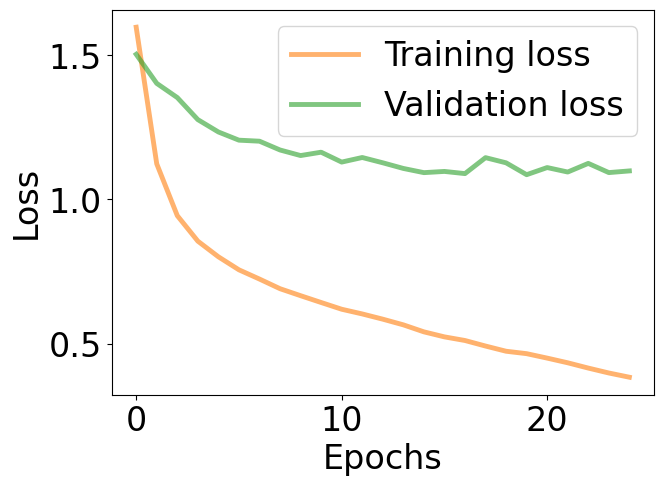

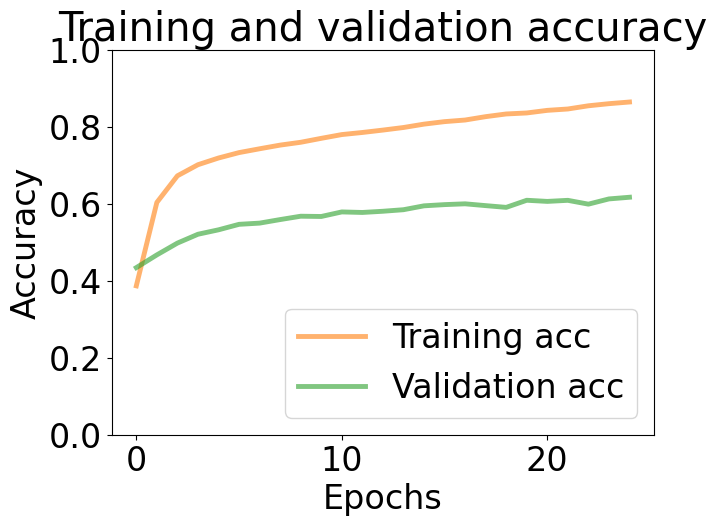

225/225 [==============================] - 3s 12ms/step
              precision    recall  f1-score   support

           0       0.55      0.45      0.50       958
           1       0.89      0.38      0.53       111
           2       0.49      0.43      0.46      1024
           3       0.73      0.85      0.79      1774
           4       0.51      0.64      0.56      1233
           5       0.54      0.41      0.47      1247
           6       0.72      0.75      0.73       831

    accuracy                           0.61      7178
   macro avg       0.63      0.56      0.58      7178
weighted avg       0.60      0.61      0.60      7178



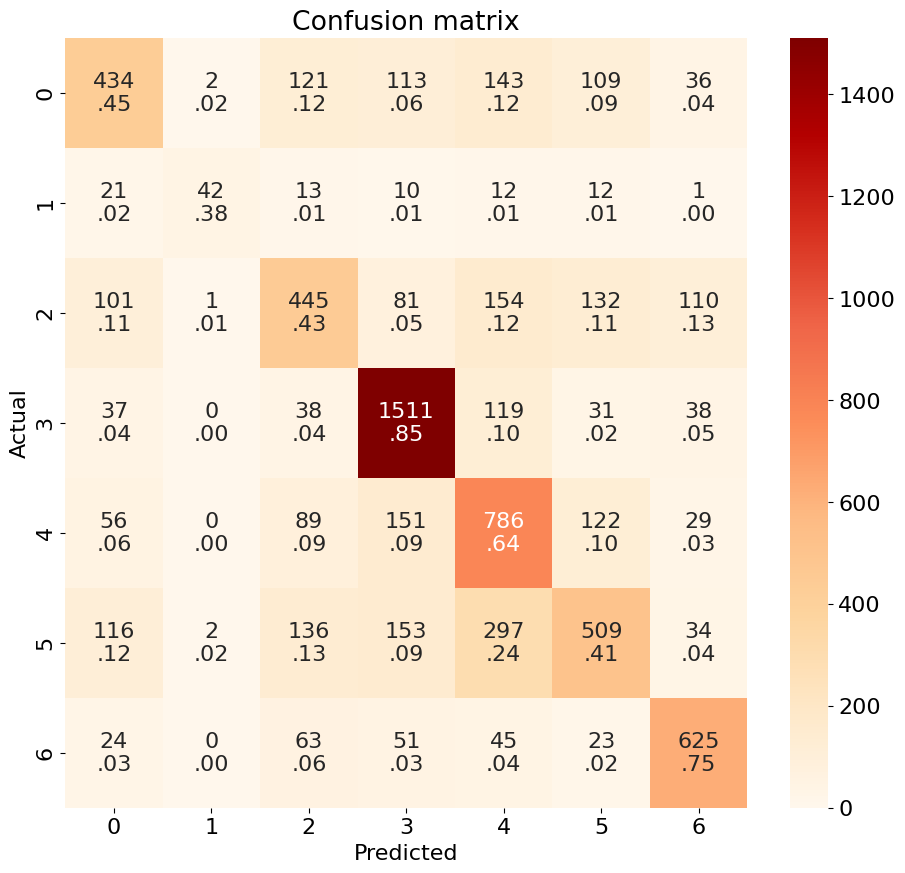

In [ ]:
import matplotlib.pyplot as plt

# Convert labels to categorical format
categorical_label_test = to_categorical(label_test_np)

plot_accurancy_loss(history)
evaluateClassifier(model, image_test_norm, categorical_label_test)